In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import scipy
from lagged_autocoherence import lagged_hilbert_autocoherence
from utils import scale_noise
import colorednoise as cn

In [2]:
def gen_signal_bursts(T, n_trials, srate, f, n_cycles, num_bursts, snr_db):
    dt=1/srate
    time = np.linspace(0, T, T * srate)
    signal=np.zeros((n_trials, len(time)))

    for trial in range(n_trials):
        # Burst signal
        s1=np.zeros((len(time)))

        # Keep track of burst start and stop times so they
        # don't overlap
        burst_starts=[]
        burst_stops=[]

        # Burst duration in seconds
        dur_s=n_cycles/f
        # Burst duration in time steps
        dur_pts=int(dur_s/dt)

        # Random start and stop time
        start=np.random.randint(0,len(time)-dur_pts)
        stop=start+dur_pts
        s1[start:stop]=np.sin(2. * np.pi * f1 * (time[start:stop]-time[start]))
        burst_starts.append(start)
        burst_stops.append(stop)

        while len(burst_starts)<num_bursts:
            # Random start and stop time
            start=np.random.randint(int(T/dt)-dur_pts)
            stop=start+dur_pts

            # Check that doesn't overlap with other bursts
            overlap=False
            for (other_start,other_stop) in zip(burst_starts,burst_stops):
                if (start >= other_start and start < other_stop) or (stop > other_start and stop <= other_stop):
                    overlap=True
                    break

            # Generate burst
            if not overlap:
                s1[start:stop]=np.sin(2. * np.pi * f1 * (time[start:stop]+np.random.randn()))
                burst_starts.append(start)
                burst_stops.append(stop)

        # Generated signal
        noise = cn.powerlaw_psd_gaussian(1, len(time))
        scaled_noise = scale_noise(s1, noise, snr_db)
        signal[trial,:]=s1+scaled_noise
    return signal

In [3]:
# --- Generate signal and compute LHaC ---

# Duration (s)
T=10
# Sampling rate
srate=500
time=np.linspace(0,T,T*srate)

# Burst frequency
f1 = 15
# Length of bursts in cycles
f1_num_cycles=5
# Number of bursts
f1_num_bursts=1

n_trials=100

snr_db = -10
f_min = 5
f_max = 100

signal = gen_signal_bursts(T, n_trials, srate, f1, f1_num_cycles, f1_num_bursts, snr_db)

freqs, psd = scipy.signal.welch(signal, fs=srate, window='hann',
                                nperseg=srate, noverlap=int(srate / 2), nfft=srate * 2, detrend='constant',
                                return_onesided=True, scaling='density', axis=- 1, average='mean')
idx = (freqs >= f_min) & (freqs <= f_max)
freqs = freqs[idx]
psd = psd[:, idx]

In [4]:
fixed_cyc_inc=0.5
max_cycles=[2,4,6,8,10]

max_cycle_lhc=[]
max_cycle_lags=[]
for m in max_cycles:
    lags = np.arange(fixed_cyc_inc, m+fixed_cyc_inc, fixed_cyc_inc)

    lhc = lagged_hilbert_autocoherence(signal, freqs, lags, srate, n_jobs=-1)
    max_cycle_lhc.append(lhc)
    max_cycle_lags.append(lags)

In [5]:
cyc_inc=[0.1, 0.5, 1, 2]
fixed_max_cycles=10

cyc_inc_lhc=[]
cyc_inc_lags=[]
for i in cyc_inc:
    lags = np.arange(i, fixed_max_cycles+i, i)

    lhc = lagged_hilbert_autocoherence(signal, freqs, lags, srate, n_jobs=-1)
    cyc_inc_lhc.append(lhc)
    cyc_inc_lags.append(lags)

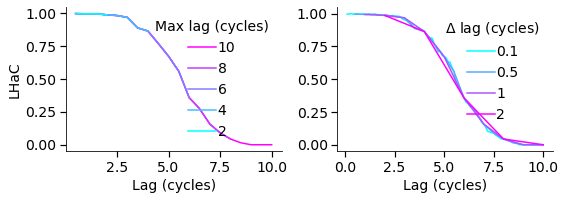

In [9]:
plt.rcParams.update({
    'font.size': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'xtick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.size': 6,
    'ytick.major.width': 1.2,
    'legend.frameon': False,
    'legend.handletextpad': 0.1,
    'svg.fonttype': 'none',
    'text.usetex': False
})

f_idx=np.argmin(np.abs(freqs-f1))

fig=plt.figure(figsize=(8,3))
ax=plt.subplot(1,2,1)
colors = cm.cool(np.linspace(0, 1, len(max_cycles)))
for idx in reversed(range(len(max_cycles))):
    ax.plot(max_cycle_lags[idx], np.mean(max_cycle_lhc[idx][:,f_idx,:], axis=0), 
            color=colors[idx], label=f'{max_cycles[idx]}')
plt.legend(title='Max lag (cycles)')
ax.set_xlabel('Lag (cycles)')
ax.set_ylabel('LHaC')
    
ax=plt.subplot(1,2,2)
colors = cm.cool(np.linspace(0, 1, len(cyc_inc)))
for idx in range(len(cyc_inc)):
    ax.plot(cyc_inc_lags[idx], np.mean(cyc_inc_lhc[idx][:,f_idx,:], axis=0), 
            color=colors[idx], label=f'{cyc_inc[idx]}')
plt.legend(title=r'$\Delta$ lag (cycles)', loc='upper right')
ax.set_xlabel('Lag (cycles)')

plt.tight_layout()
fig.savefig('../output/figures/figure_s2.pdf')